# Harmonic oscillator - interpolation and nonlinear fit

This notebook is used for analysis of the oscillation data from the first Tier 1 Lab of Phys 5BL.

For more details on the theory behind the various oscillator models, see the lab manual. 

The case of the constant-friction oscillator is handled differently than the other two, and is done at the end of the notebook.

## Data loading and interpolation

Unlike for the Hooke's law fitting, in this case doing the interpolation is not strictly necessary. However, we still choose to do it so that the fit converges more quickly (this was more important on the excel version of this notebook).


In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check the data and headers
file = open('dataset-f2d01-t1-1-part3.csv', 'r')
print(file.read())

Time (s),Ay (m/s),F (N),r (m)
0.01,-8.551339149,0.000561258,0
0.02,-8.553758621,0.000561258,0
0.029999999,-8.552931786,0.000561258,0
0.039999999,-8.557154655,0.002151513,0
0.050000001,-8.558380127,0.003741768,0
0.059999999,-8.560379982,0.003741768,0
0.07,-8.56199646,0.005332023,0
0.079999998,-8.559652328,0.004536896,0
0.090000004,-8.557974815,0.003741768,0
0.100000001,-8.554954529,0.003741768,0
0.109999999,-8.551038742,0.00294664,0
0.119999997,-8.55138588,0.003741768,0
0.129999995,-8.553726196,0.003741768,0
0.140000001,-8.555350304,0.00294664,0
0.150000006,-8.557484627,0.003741768,0
0.159999996,-8.557988167,0.00294664,0
0.170000002,-8.555830956,0.002151513,0
0.180000007,-8.556651115,0.002151513,0
0.189999998,-8.558793068,0.000561258,0
0.200000003,-8.558904648,0.000561258,0
0.209999993,-8.560210228,0.001356385,0
0.219999999,-8.558251381,0.00294664,0
0.230000004,-8.555717468,0.003741768,0
0.239999995,-8.555519104,0.004536896,0
0.25,-8.557579041,0.006127151,0
0.25999999,-8.560547829,0.005

In [3]:
# Input the data into arrays. You might also want to look at the wheel output, to better choose the quietest sensor
tx, aydata, Fdata, rdata= np.loadtxt("dataset-f2d01-t1-1-part3.csv", delimiter=",", skiprows=1, usecols=(0,1,2,3), unpack=True)

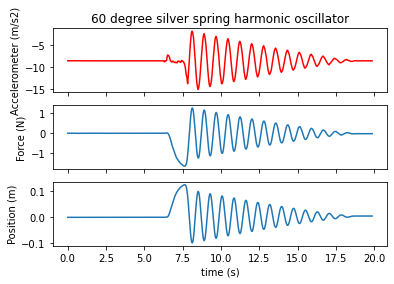

In [4]:
# Two subplots, the axes array is shared
# Choose the sensor for fitting.
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(tx, aydata,'r', label="accelerometer")
axarr[0].set_title('60 degree silver spring harmonic oscillator')
axarr[0].set_ylabel('Accelerometer (m/s2)')
axarr[1].plot(tx, Fdata)
axarr[2].plot(tx, rdata)
axarr[2].set_xlabel('time (s)')
axarr[1].set_ylabel('Force (N)')
axarr[2].set_ylabel('Position (m)')
plt.show()

## Interpolation
When using the CSV files directly output from the iOLab, you'll need to interpolate because the  different sensors have different acquisition rates. We're using linear interpolation to match the Excel spreadsheet method. The Python command:

`interp1d(tx, aydata)`

You don't need to do this for the online repository CSV files because they already are have been interpolated. You can remove the code below, if you'd like.

In [124]:
# Creates an interpolating function 
yinterp = interp1d(tx, aydata, kind="linear")

### Select region in data for fitting and interpolation

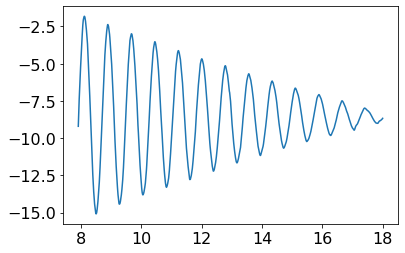

In [125]:
# Set the start time and stop time to select a good region of your data
# Use the interpolating function to estimate values at the desired time points

start_time = 7.92
stop_time = 18
step_size = 0.005
tvals = np.arange(start_time, stop_time, step_size)  
yvals = yinterp(tvals)

plt.plot(tvals, yvals)
plt.show()

## Nonlinear fits

For the cases of simple harmonic motion, and motion with velocity-dependent friction, we fit to the full time series of data. We've defined 4 models below:

Simple harmonic motion for acceleration: $a_{harmonic} = B-A\omega^2\cos(\omega t+\phi),$

Simple harmonic motion for position: $y_{harmonic} = B+A\cos(\omega t+\phi),$

Velocity-dependent friction damping for acceleration: $a_{damped}=B+A\exp^{-\beta t}[(\beta^2-\omega^2)\cos(\omega t+\phi)+2\beta\omega\sin(\omega t + \phi],$

Velocity-dependent friction damping for position: $y_{damped}=B+A\exp^{-\beta t}\cos(\omega t+\phi),$

where t is time, A is the amplitude, B is the offset, $\omega=2\pi f$ is the angular frequency, $\phi$ is the phase, $\beta$ is the damping

### Define the model:

In [126]:
# Defines the various oscillator models that we fit to:

# Simple harmonic motion using acceleration
def simple_a(t, A, B, w, phi):                  # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B - A * (w**2) * np.cos(w*t + phi)   # output: acceleration

# Simple harmonic motion using position
def simple_y(t, A, B, w, phi):       # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B + A*np.cos(w*t + phi)   # output: position

# Velocity-dependent friction using acceleration
def vdamped_a(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * ((beta**2-w**2)*np.cos(w*t + phi)+2*beta*w*np.sin(w*t+phi))   # output: acceleration

# Velocity-dependent friction using position
def vdamped_y(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * np.cos(w*t + phi)        # output: position



### Choose the model and initial fit parameter values then graph:


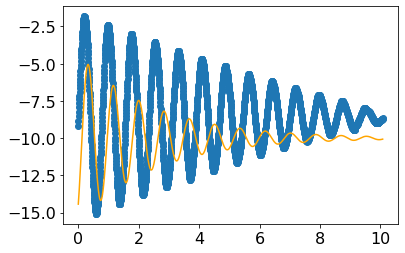

In [139]:
# Fits to the nonlinear function

# Choose the model you wish to fit to: simple_y, simple_a, vdamped_y, vdamped_a
oscillator_model = vdamped_a
# oscillator_model=simple_a


# Initial guess values of fit parameters
    # If using simple_a or simple_y:  [A, B, w, phi]
    # If using vdamped_a or vdamped_y: [ A, B, w, phi, beta]

Ainit, Binit, winit, phiinit, betainit=[0.1, -10, 7.5, 0.56, 0.4]

# Graph
plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit, betainit), color='orange')
# plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit), color='orange')
plt.scatter(tvals-start_time, yvals)
plt.show()


## Perform the fit then plot

In [140]:
# Perform the fit
start_pars=[Ainit, Binit, winit, phiinit, betainit]
# start_pars=[Ainit, Binit, winit, phiinit]
# pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars, betainit)
pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)

# [A, B, w, phi] = pars
[A, B, w, phi, beta] = pars
std_errs = np.sqrt(np.diag(cov))

# print(np.transpose([pars, std_errs]))

# [A, B, w, phi] = pars
[A, B, w, phi, beta] = pars
std_errs = np.sqrt(np.diag(cov))

print(np.transpose([pars, std_errs]))

[[ 1.16075785e-01  3.74864280e-04]
 [-8.55593280e+00  5.79042919e-03]
 [ 8.08378721e+00  9.87228331e-04]
 [ 1.39379313e+00  3.18546911e-03]
 [ 1.89826073e-01  9.95318597e-04]]


In [129]:
# Values predicted from fit
ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta)
# ypred = oscillator_model(tvals-start_time, A, B, w, phi)

# For damped harmonic fit, use: ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta)

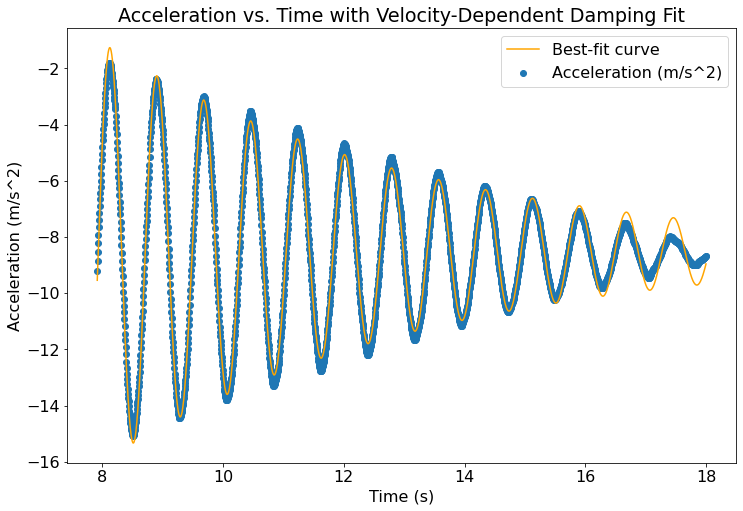

In [130]:
## Best-fit plots

# Sets figure size etc.
fig1=plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(tvals, yvals, label='Acceleration (m/s^2)')
plt.plot(tvals, ypred, color='orange', label='Best-fit curve')


# Axes label and title
plt.title("Acceleration vs. Time with Velocity-Dependent Damping Fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.legend()
# plt.show()

plt.savefig('part3-vdamp.png')

## Constant friction case 

Instead of fitting the full trajectory, we instead compare the amplitudes of successive extrema (turning points). The general equation is:
$$A_n-A_{n+1}=\frac{2f}{k}$$
where $f$ is the coefficient of static friction and $A_n$ is the amplitude for the nth peak. Successive turning points are a maximum followed by a minimum (or vice versa).

There are scipy functions that find these extrema well, but it is also not too hard to do it manually.

In [17]:
from scipy.signal import argrelextrema as get_extrema_indices

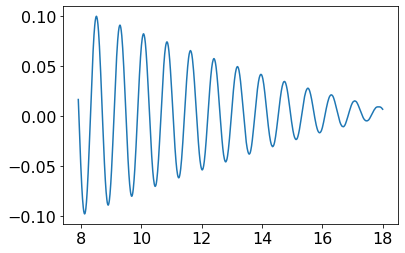

In [72]:
# Creates an interpolating function 
rinterp = interp1d(tx, rdata, kind="linear")
start_time = 7.92
stop_time = 18
step_size = 0.005
tvals = np.arange(start_time, stop_time, step_size)  
rvals = rinterp(tvals)

plt.plot(tvals, rvals)
plt.show()

In [73]:
# How many neighboring points to compare to for min/max criteria
neighborhood_size = 5

max_indices = get_extrema_indices(rvals, np.greater_equal, order=neighborhood_size)
min_indices = get_extrema_indices(rvals, np.less_equal, order=neighborhood_size)

print("Maxima found: ", np.size(max_indices))
print("Minima found: ", np.size(min_indices))

Maxima found:  32
Minima found:  29


In [74]:
r_max = rvals[max_indices]
t_max = tvals[max_indices]

r_min = rvals[min_indices]
t_min = tvals[min_indices]

In [75]:
print(r_max, t_max)
print(r_min, t_min)

[0.0163334  0.09955554 0.09066666 0.08199999 0.07388889 0.06522223
 0.05722222 0.04922221 0.04144444 0.04144444 0.03433333 0.03433333
 0.03433333 0.02766666 0.021      0.015      0.009      0.009
 0.009      0.009      0.009      0.009      0.009      0.009
 0.009      0.009      0.009      0.009      0.009      0.009
 0.009      0.009     ] [ 7.92   8.52   9.3   10.08  10.855 11.63  12.41  13.19  13.965 13.97
 14.74  14.745 14.75  15.52  16.295 17.07  17.82  17.825 17.83  17.835
 17.84  17.845 17.85  17.855 17.86  17.865 17.87  17.875 17.88  17.885
 17.89  17.895]
[-0.098      -0.08922222 -0.08033332 -0.07044444 -0.07044444 -0.06188889
 -0.06188889 -0.06188889 -0.05399999 -0.046      -0.03822222 -0.03077777
 -0.02366667 -0.01688889 -0.01688889 -0.01088889 -0.01088889 -0.005
 -0.005      -0.005      -0.005      -0.005       0.009       0.009
  0.009       0.009       0.009       0.009       0.00661111] [ 8.13   8.91   9.69  10.465 10.47  11.24  11.245 11.25  12.02  12.8
 13.58  14.35  

* At this point, we manually select the peaks such that there is only one datapoint per local extremum.

In [70]:
# For F values
max_index_set = [0,2,3,4,5,6,7,8,9,10,11,12,13]
r_max_indexed = r_max[max_index_set]
t_max_indexed = t_max[max_index_set]
print(np.diff(r_max_indexed))

min_index_set = [1,2,3,4,5,6,7,8,9,10,11,13,15]
r_min_indexed = r_min[min_index_set]
t_min_indexed = t_min[min_index_set]
print(np.diff(r_min_indexed))

[-0.10575193 -0.11529361 -0.11052263 -0.10654701 -0.10734212 -0.10257155
 -0.10177625 -0.08825939 -0.08666866 -0.08587377 -0.08110301 -0.06997121]
[0.11131775 0.11767885 0.10734237 0.10575184 0.10257134 0.09939106
 0.10813717 0.08189813 0.09143972 0.08269321 0.07156146 0.06122482]


In [76]:
# For r values
max_index_set = [1,2,3,4,5,6,7,8,10,13,14,15,16]
r_max_indexed = r_max[max_index_set]
t_max_indexed = t_max[max_index_set]
print(np.diff(r_max_indexed))

min_index_set = [0,1,2,3,5,8,9,10,11,12,13,15,17]
r_min_indexed = r_min[min_index_set]
t_min_indexed = t_min[min_index_set]
print(np.diff(r_min_indexed))

[-0.00888888 -0.00866667 -0.00811111 -0.00866666 -0.00800001 -0.00800001
 -0.00777777 -0.00711111 -0.00666667 -0.00666666 -0.006      -0.00599999]
[0.00877778 0.0088889  0.00988887 0.00855555 0.0078889  0.00799999
 0.00777778 0.00744446 0.0071111  0.00677778 0.006      0.00588889]


0.7749999999999834 0.777083333333317


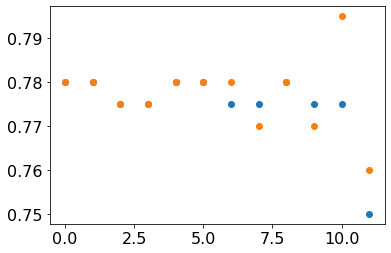

In [135]:
t_maxd = np.diff(t_max_indexed)
t_mind =  np.diff(t_min_indexed)
plt.scatter(range(len(t_maxd)), t_maxd)
plt.scatter(range(len(t_mind)), t_mind)
print(np.mean(t_maxd), np.mean(t_mind))

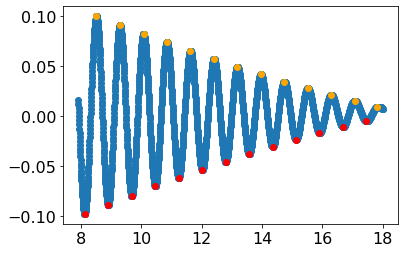

In [82]:
# Make a plot to check the  located max, min are in the right place 
# Be sure to check that the number of maxima, minima that appear on the plot are the same as what's printed above

plt.scatter(tvals, rvals)
plt.scatter(t_max_indexed, r_max_indexed, color='orange')
plt.scatter(t_min_indexed, r_min_indexed, color='red')
plt.show()

Giving these maxima and minima, it's now up to you to define an appropriate function for evaluating the model given above (and on page 4 of the lab manual).

[0.1000000012000219, 0.09755554373342297, 0.09122221620019406, 0.08866666275567543, 0.08233331600037785, 0.0799999923334709, 0.072444442, 0.071888886500014, 0.063888888, 0.06322223033334906, 0.055999989666755734, 0.0552222246666588, 0.047999997888881395, 0.047222213666935166, 0.04022222222227558, 0.039444442999999996, 0.03277776533370872, 0.032333333, 0.02566666577778219, 0.025666660888917753, 0.018888889, 0.019000000000000003, 0.012888889, 0.012999995555671382, 0.007, 0.0070000010000000005]


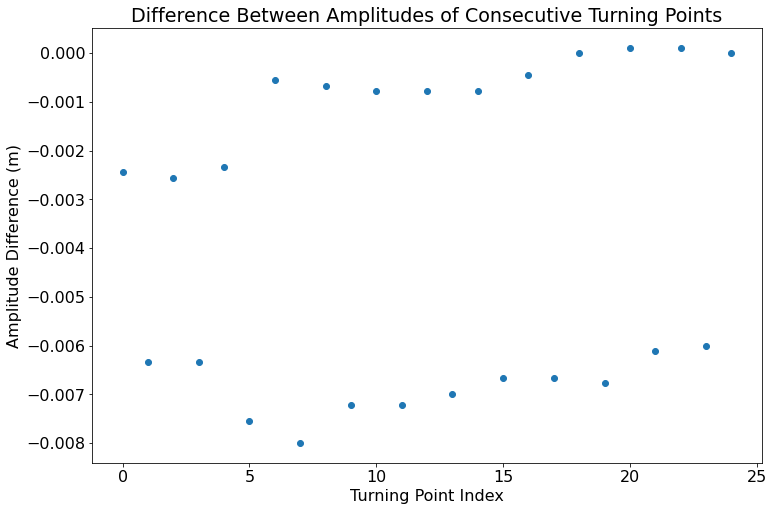

In [103]:
plt.figure(figsize=(12,8))
# Define your function here
amplitudes = []
for i in range(len(r_max_indexed)):
    amplitudes += [0.002-r_min_indexed[i]]
    amplitudes += [r_max_indexed[i]-0.002]

print(amplitudes)
diffs = np.diff(amplitudes)
plt.scatter(range(len(diffs)), diffs)
plt.title('Difference Between Amplitudes of Consecutive Turning Points')
plt.xlabel('Turning Point Index')
plt.ylabel('Amplitude Difference (m)')
plt.savefig('turning-pts.png')

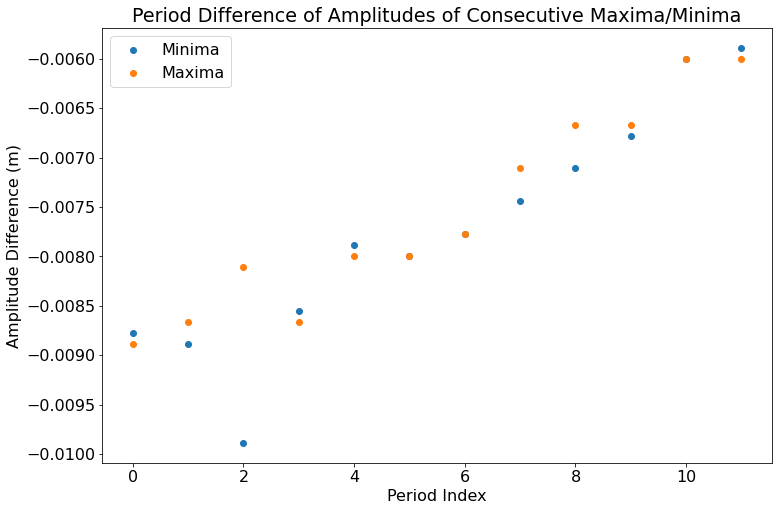

In [104]:
plt.figure(figsize=(12,8))
min_diff = np.diff(-r_min_indexed)
plt.scatter(range(len(min_diff)), min_diff, label='Minima')
max_diff = np.diff(r_max_indexed)
plt.scatter(range(len(max_diff)), max_diff, label='Maxima')
plt.xlabel('Period Index')
plt.ylabel('Amplitude Difference (m)')
plt.title('Period Difference of Amplitudes of Consecutive Maxima/Minima')
plt.legend()
plt.savefig('minmax.png')